# Stochastic Variational Method with RL algorithms

In [1]:
import numpy as np
import gym
import svm_env as svm
import torch
import subprocess

## Expoloring environment

In [2]:
env = gym.make('svm_env:svmEnv-v0', file_sigmas ="./svmCodeSVD/sigmas.dat" )

obs_space = env.observation_space

print('###### Observation space ####### \n', obs_space)

state_size = env.observation_space.shape[-1]

print('###### Size of observation space ####### \n', state_size)

act_space = env.action_space

print('###### Action space ####### \n', act_space)

act_size = env.action_space.shape[-1]

print('###### Number of actions ####### \n', act_size)

state = env.reset()

print('##### State after reset ###### \n', state)

print('##### File where will be stored sigmas \n', env.file_sigmas)

###### Observation space ####### 
 Box(-inf, inf, (1,), float32)
###### Size of observation space ####### 
 1
###### Action space ####### 
 Box(-1.0, 1.0, (3,), float32)
###### Number of actions ####### 
 3
#### CALL RESET ####
Action chosen at reset:  [0.]
Actions taken at reset:  []
Energies got at reset:  [0.0]
##### State after reset ###### 
 [0.]
##### File where will be stored sigmas 
 ./svmCodeSVD/sigmas.dat


## Twin Delayed DDPG (TD3) from `stable_baseline3`

In [ ]:
from stable_baselines3 import DDPG
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise

# The noise objects for DDPG
action_noise = NormalActionNoise(mean=np.zeros(act_size), sigma=0.2 * np.ones(act_size))

model = DDPG("MlpPolicy", env, action_noise = action_noise, \
            learning_starts=150, batch_size=150, gamma=1.0, verbose=1, seed = 2)

# (policy, env, learning_rate=0.001, buffer_size=1000000,learning_starts=100, batch_size=100, 
# tau=0.005, gamma=0.99, train_freq=(1, 'episode'),  gradient_steps=- 1, action_noise=None, 
# replay_buffer_class=None, replay_buffer_kwargs=None,  optimize_memory_usage=False, 
# tensorboard_log=None, create_eval_env=False, policy_kwargs=None,  verbose=0, seed=None, 
# device='auto', _init_setup_model=True)

model.learn(total_timesteps=500, log_interval = 5, n_eval_episodes = 1)

# learn(total_timesteps, callback=None, log_interval=4, eval_env=None, eval_freq=- 1,
# n_eval_episodes=5, tb_log_name='DDPG', eval_log_path=None, reset_num_timesteps=True)

## PPO with GAE from `stable_baseline3` 

In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

model = PPO("MlpPolicy", env, verbose=1, n_steps = 2, batch_size = 64, gamma = 1.0)

# classstable_baselines3.ppo.PPO(policy, env, learning_rate=0.0003, n_steps=2048, 
#         batch_size=64, n_epochs=10, gamma=0.99, gae_lambda=0.95, clip_range=0.2, 
#         clip_range_vf=None, ent_coef=0.0, vf_coef=0.5, max_grad_norm=0.5, 
#         use_sde=False, sde_sample_freq=- 1, target_kl=None, tensorboard_log=None, 
#         create_eval_env=False, policy_kwargs=None, verbose=0, seed=None, device='auto', 
#         _init_setup_model=True)

model.learn(total_timesteps = 350, n_eval_episodes = 1)

# learn(total_timesteps, callback=None, log_interval=1, eval_env=None, eval_freq=- 1, 
#       n_eval_episodes=5, tb_log_name='PPO', eval_log_path=None, reset_num_timesteps=True)

model.save("ppo_svm")

In [ ]:
model = PPO.load("ppo_svm")

obs = env.reset()
rewards = []
score = 0.0
while True:
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    env.render()
    

## From my `ddpg_agent.py` code

In [ ]:
from ddpg_agent import Agent

In [ ]:
env = gym.make('svm_env:svmEnv-v0')
# Instance of the ddpg agent
agent = Agent(1, 3, random_seed=2)

### Training loop
def run_ddpg(max_t_step = 500, n_episodes = 1000):        
    """Deep Deterministic Policy Gradient learning for Reacher Unity Environment.
    
    Params Input
    ==========
        n_episode (int): maximum number of episodes
        queue (int): number of consecutive episodes 
        
    Params Output
    ==========
        scores_all (list of floats): are the scores collected at the end of each episode
        
    """
    
    ##Inizialization
    scores = []                         
    last_energies = []
    princip_dim = []
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        agent.reset()                  
        score = 0.0
               
        ## Training loop of each episode
        for t_step in range(max_t_step):
            action = agent.act(state)
            next_state, reward, done, info = env.step(action)                   
            agent.step(state, action, reward, next_state, done)
            score += reward
            state = next_state  
            if done:                                  
                break
        
        scores.append(score)
        last_energies.append(state[0])
        princip_dim.append(env.princp_dim)
        
        print('Episode {} ... Reward: {:.3f}'.format(i_episode, score))

    return scores, last_energies, princip_dim

In [ ]:
scores, energies, princip_dim = run_ddpg()
torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')

### Benchmarcks and plots

Text(0.5, 0, 'Episode #')

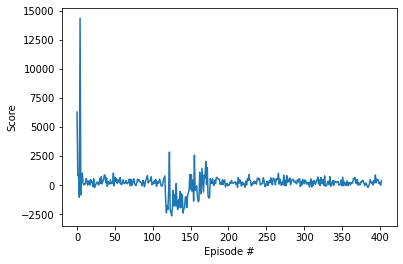

In [5]:
import matplotlib.pyplot as plt

scores = np.loadtxt('scores_RL.out')
energies = np.loadtxt('energies_RL.out')
dim = np.loadtxt('princip_dim_RL.out')

plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')

Text(0.5, 0, 'Episode #')

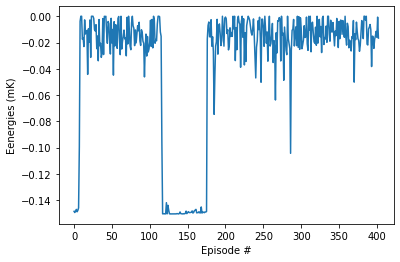

In [6]:
plt.plot(np.arange(len(energies)), energies)
plt.ylabel('Eenergies (mK)')
plt.xlabel('Episode #')

Text(0.5, 0, 'Episode #')

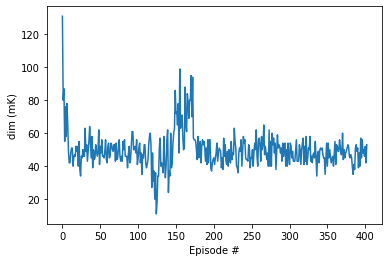

In [7]:
plt.plot(np.arange(len(dim)), dim)
plt.ylabel('dim (mK)')
plt.xlabel('Episode #')

In [18]:
rewards = []

for i in range(10):
    rew_i_episode = []
    for j in range(20):
        rew_i_episode.append(j)
    rewards.append(rew_i_episode)

name_rewards = 'rewards_RL.out'
file_rewards = open(name_rewards,'w')
np.savetxt(file_rewards, rewards, fmt="%f")
file_rewards.close()

## Random search as in original SVM

In [ ]:
state = env.reset()
scores = []
step = 0
score = 0.0

while True:
    print(".....STEP.....", step)
    action = env.action_space.sample()
    next_state, reward, done, info = env.step(action)
    step = step + 1
    score += reward
    scores.append(score)
    state = next_state
    if done:
        break